# Modeling Pipeline for Phishing URL Detection

In this notebook, we build a full modeling pipeline for detecting phishing URLs.  
We start with a dataset that contains two columns: a **URL** and a **label** indicating whether the URL is **benign** or **phishing**.

While we use a well-known research dataset for this example, **any dataset with labeled URLs** can be used — because **all features in this pipeline will be created from scratch** using custom Python functions.

📘 **Dataset citation**:  

> [1] S. Marchal, J. Francois, R. State, and T. Engel.  
> *PhishStorm: Detecting Phishing with Streaming Analytics*.  
> IEEE Transactions on Network and Service Management (TNSM), 11(4):458–471, 2014.


## Set up

In [ ]:
# Load packages
from detecting_phishing_urls.load_data import load_phishing_data, load_alexa_domains
from detecting_phishing_urls.features import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score
from sklearn.model_selection import GridSearchCV


First, let's load our main dataset with URLs and labels.

In [2]:
# Load the PhishStorm dataset

df = load_phishing_data(
    data_dir='../data',
    filename='urlset.csv', 
    url_col='domain',        
    label_col='label'     
)

# Quick preview
df.head()

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [3]:
df.shape

(95913, 2)

Next, let's load a list of the most visited domains globally from the Alexa Top 1M dataset. This list serves as a proxy for trusted or popular websites.

We'll use it later to engineer features that indicate whether a domain in a URL appears in this trusted set, which may help differentiate between phishing and legitimate URLs.


In [4]:
# Load the Alexa domain list
alexa_df = load_alexa_domains(
    data_dir='../data',
    filename='alexa_domains_1M.txt'
)

alexa_df.head()


,alexa_domain,rank
0,google.com,1
1,facebook.com,2
2,youtube.com,3
3,baidu.com,4
4,yahoo.com,5


## Feature engineering

### Alexa-based features

We use the Alexa Top 1M domain list to generate two features that indicate how globally popular or common a domain is:

- **`is_in_alexa`**: A binary flag indicating whether the main-level domain (`mld_ps`) of the URL is in the Alexa Top 1M list (1 = yes, 0 = no).
- **`ranking`**: The popularity rank of the domain (1 = most popular). If the domain is not in Alexa, we impute it with 1,000,001 - just outside the Top 1M.

These features are based on the assumption that phishing URLs are less likely to use popular or trusted domains.


In [5]:
# Add mld_ps column
df = add_mld_feature(df)

# Add is_in_alexa and ranking features
df = add_alexa_rank_feature(df, alexa_df)

# Preview
df[['url', 'mld_ps', 'is_in_alexa', 'ranking']].head(50)


,url,mld_ps,is_in_alexa,ranking
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,nobell.it,0.0,1000001.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,dghjdgf.com,0.0,1000001.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,serviciosbys.com,0.0,1000001.0
3,mail.printakid.com/www.online.americanexpress....,printakid.com,0.0,1000001.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,thewhiskeydregs.com,0.0,1000001.0
5,smilesvoegol.servebbs.org/voegol.php,servebbs.org,0.0,1000001.0
6,premierpaymentprocessing.com/includes/boleto-2...,premierpaymentprocessing.com,0.0,1000001.0
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,myxxxcollection.com,0.0,1000001.0
8,super1000.info/docs,super1000.info,0.0,1000001.0
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,horizonsgallery.com,0.0,1000001.0


In [6]:
df[['is_in_alexa', 'ranking']].describe()

,is_in_alexa,ranking
count,95821.000000,9.582100e+04
mean,0.393525,6.541718e+05
std,0.488534,4.502520e+05
min,0.000000,1.000000e+00
25%,0.000000,3.599800e+04
50%,0.000000,1.000001e+06
75%,1.000000,1.000001e+06
max,1.000000,1.000001e+06


### Jaccard-based features: measuring token similarity in URLs

We introduce two Jaccard similarity features to capture structural overlap between parts of a URL and its main domain:

1. **`jaccard_mld_path`**: Measures the overlap of tokens between the main domain (`mld_ps`) and the URL path.
   - Example: Comparing `paypal.com` with `/paypal/login` → high similarity.
   - Phishing URLs often reuse brand names in the path to mislead users.

2. **`jaccard_subdomain_path`**: Measures overlap between the *subdomain* and the path.
   - Example: Comparing `accounts.paypal.com` with `/paypal/signin` might show higher overlap.
   - Phishing sites may encode target keywords in both subdomains and paths.

These features are helpful because benign domains often have meaningful, structured URL paths, while phishing domains tend to reuse brand names inconsistently across subdomains and paths.

We compute these similarities using the **Jaccard index**, which compares the intersection and union of token sets. A higher value indicates greater structural overlap.

Let’s now generate and explore these features:


In [7]:
df = extract_jaccard_features(df)
df[["jaccard_mld_path", "jaccard_subdomain_path"]].describe()

,jaccard_mld_path,jaccard_subdomain_path
count,95913.000000,95913.000000
mean,0.005719,0.007234
std,0.033786,0.043152
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


### URL entropy feature

To help detect suspicious or phishing URLs, we added a feature called `url_entropy`.

Entropy, in this context, refers to **Shannon entropy** — a measure from information theory that quantifies the **randomness** or **unpredictability** of characters in a string.

It is calculated using the formula:

$$
\text{Entropy}(S) = - \sum_{c \in S} p(c) \log_2 p(c)
$$

Where:
- \( S \) is the string (e.g., a URL)
- \( p(c) \) is the frequency of character \( c \) in the string

Legitimate URLs tend to be simple, readable, and structured (e.g., `nytimes.com/news`). In contrast, phishing URLs often contain:
- Random character sequences
- Encoded strings
- Obfuscated domains or paths

These characteristics increase the entropy of the URL.

So in general:
- ✅ Lower entropy → more likely legitimate  
- ⚠️ Higher entropy → more likely suspicious

We compute Shannon entropy on the entire `url`, after ensuring it has a valid scheme (`http` or `https`). This feature (`url_entropy`) can be used directly in modeling as a continuous variable.


In [8]:
# Apply entropy feature
df = add_entropy_feature(df)

# Preview the result
df[['url', 'url_entropy']].head()

,url,url_entropy
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,5.046608
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,4.720685
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,4.739902
3,mail.printakid.com/www.online.americanexpress....,4.179853
4,thewhiskeydregs.com/wp-content/themes/widescre...,4.623373


In [9]:
df['url_entropy'].describe()

count    95913.000000
mean         4.296006
std          0.418681
min          2.513493
25%          4.017918
50%          4.204470
75%          4.494993
max          7.233637
Name: url_entropy, dtype: float64

### URL structure & semantic features

We create several handcrafted features to help detect phishing URLs based on known patterns and behaviors.

These include:

| Feature | Description |
|--------|-------------|
| **`num_digits`** | Count of digits (`0–9`) in the full URL. Phishing URLs often contain numbers to appear unique or evade filters. |
| **`url_length`** | Total number of characters in the full URL. Long URLs are commonly used to hide the true domain. |
| **`num_subdomains`** | Number of subdomains before the main domain. For example, `paypal.security.login.com` has 2 subdomains. |
| **`num_path_segments`** | Number of segments in the URL path, separated by `/`. Deep paths may indicate obfuscation. |
| **`num_suspicious_keywords`** | Count of suspicious tokens like `login`, `secure`, `account`, etc. These often appear in phishing attempts. |
| **`num_special_chars`** | Number of non-alphanumeric characters (e.g., `-`, `_`, `%`) used for obfuscation. |
| **`has_brand_conflict`** | `True` if the domain contains one brand (e.g. `apple`) and the path contains another (e.g. `paypal`). This mismatch can be a red flag. |

These structural and semantic signals are lightweight yet informative and can help distinguish benign from malicious URLs in our classification model.


In [10]:
# Apply the full feature extractor
df = add_url_structure_features(df)

# Preview all new features
df[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].head()



,url,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,58,232,0,8,3,35,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,88,1,4,1,18,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,47,184,0,10,4,22,0
3,mail.printakid.com/www.online.americanexpress....,0,67,1,2,0,11,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,21,123,0,6,0,16,0


In [11]:
df[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].describe()

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars
count,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000
mean,8.134987,71.325628,1.336169,2.389509,0.466402,11.694828
std,19.356985,64.847906,1.952652,1.710235,1.084260,7.304577
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,37.000000,1.000000,1.000000,0.000000,7.000000
50%,1.000000,49.000000,1.000000,2.000000,0.000000,9.000000
75%,5.000000,78.000000,1.000000,3.000000,0.000000,13.000000
max,286.000000,2182.000000,33.000000,34.000000,17.000000,229.000000


In [12]:
df.describe()

,label,is_in_alexa,ranking,jaccard_mld_path,jaccard_subdomain_path,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars
count,95913.000000,95821.000000,9.582100e+04,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000
mean,0.499453,0.393525,6.541718e+05,0.005719,0.007234,4.296006,8.134987,71.325628,1.336169,2.389509,0.466402,11.694828
std,0.500002,0.488534,4.502520e+05,0.033786,0.043152,0.418681,19.356985,64.847906,1.952652,1.710235,1.084260,7.304577
min,0.000000,0.000000,1.000000e+00,0.000000,0.000000,2.513493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.599800e+04,0.000000,0.000000,4.017918,0.000000,37.000000,1.000000,1.000000,0.000000,7.000000
50%,0.000000,0.000000,1.000001e+06,0.000000,0.000000,4.204470,1.000000,49.000000,1.000000,2.000000,0.000000,9.000000
75%,1.000000,1.000000,1.000001e+06,0.000000,0.000000,4.494993,5.000000,78.000000,1.000000,3.000000,0.000000,13.000000
max,1.000000,1.000000,1.000001e+06,1.000000,1.000000,7.233637,286.000000,2182.000000,33.000000,34.000000,17.000000,229.000000


## Train-test split

In [13]:
feature_cols = [
    'is_in_alexa', 'ranking',
    'jaccard_mld_path', 'jaccard_subdomain_path',
    'url_entropy', 'num_digits', 'url_length',
    'num_subdomains', 'num_path_segments',
    'num_suspicious_keywords', 'num_special_chars',
    'has_brand_conflict'
]

In [14]:
# Drop rows with missing labels
df = df.dropna(subset=["label"])

# Check for missing values in other columns
missing_counts = df.isna().sum()

# Show only columns that have missing values
missing_counts[missing_counts > 0]

is_in_alexa    92
ranking        92
dtype: int64

In [15]:
# Drop rows with missing values in label, is_in_alexa, or ranking
df = df.dropna(subset=["label", "is_in_alexa", "ranking"])

In [16]:
# Define X and y
X = df[feature_cols]
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Feature scaling

This will ensure all features have zero mean and unit variance, which helps those algorithms converge faster and make more balanced decisions.

In [17]:
# 3. Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 4. Use same scaler to transform test data
X_test_scaled = scaler.transform(X_test)

In [18]:
# Check dataset sizes
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

# Check label balance
print("Training label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

Training set size: 76656
Test set size: 19165
Training label distribution: Counter({0: 38333, 1: 38323})
Test label distribution: Counter({0: 9584, 1: 9581})


To ensure fair and effective modeling, we standardized our features **after performing the train-test split**. This is important because many of our features, such as `url_length`, `num_digits`, and `url_entropy`, have very different scales and distributions. Standardization (subtracting the mean and dividing by the standard deviation) brings all numeric features to a comparable scale, which is especially beneficial for models that rely on distances or gradients (e.g., logistic regression, SVM, KNN).

We applied scaling **after** the split to avoid data leakage. Fitting the scaler on the full dataset would allow information from the test set to influence the transformation applied to the training set, which could lead to inflated performance estimates. By fitting the scaler only on the training data and then applying it to both the training and test sets, we preserve the integrity of our evaluation and ensure the test set remains a valid proxy for unseen data.


## Modeling

### RF

In [19]:
# Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # helpful for imbalanced data
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [20]:
# Predict
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # for AUC

# Metrics
print("AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


AUC: 0.9638329575577288

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      9584
           1       0.91      0.88      0.89      9581

    accuracy                           0.90     19165
   macro avg       0.90      0.90      0.90     19165
weighted avg       0.90      0.90      0.90     19165

Confusion Matrix:
 [[8713  871]
 [1117 8464]]


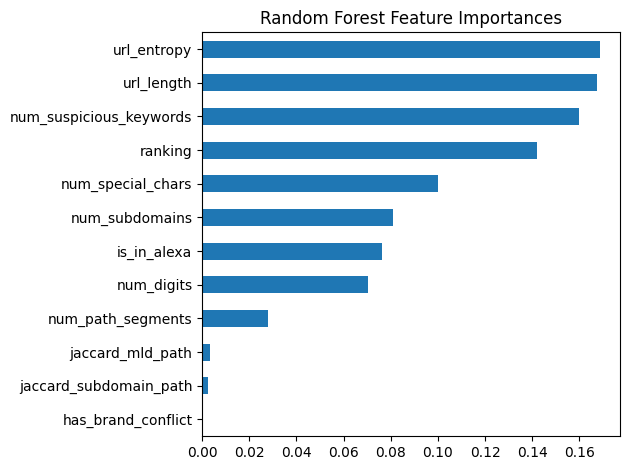

In [21]:

feature_importances = pd.Series(
    rf_model.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

feature_importances.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Hyperparameter tuning

In [22]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  43.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2,

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Best AUC:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

# Use the best model
best_rf = grid_search.best_estimator_


Best AUC: 0.97070010112583
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

print("Test AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test AUC: 0.9707432032373476

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      9584
           1       0.93      0.88      0.90      9581

    accuracy                           0.91     19165
   macro avg       0.91      0.91      0.91     19165
weighted avg       0.91      0.91      0.91     19165

Confusion Matrix:
 [[8965  619]
 [1187 8394]]


After tuning the Random Forest classifier using cross-validated GridSearchCV with AUC as the optimization metric, we identified an optimal configuration with 200 trees, a maximum depth of 20, square-root-based feature selection at each split (`max_features`='sqrt'), and default values for `min_samples_split` and `min_samples_leaf`. This configuration achieved a cross-validated AUC of 0.9707, which was confirmed by the test AUC on held-out data.

The model demonstrates strong classification performance across both phishing and legitimate URLs. Precision for phishing URLs is 0.93, indicating a low rate of false positives. Recall for phishing URLs is 0.88, showing the model successfully captures the majority of phishing threats. F1-scores for both classes are around 0.90, and overall accuracy is 91%, suggesting a well-balanced and robust model.

From the confusion matrix, we observe that 8,394 phishing URLs were correctly identified, while 1,187 were missed (false negatives). Conversely, only 619 legitimate URLs were incorrectly flagged as phishing. While some phishing URLs are still slipping through, the model effectively balances the cost of false positives and false negatives—an important trade-off in this use case, where failing to catch a phishing attempt is more risky than mistakenly flagging a benign site.

Given these results, we proceeded to finalize the model using the full training dataset and saved it for deployment or future evaluation.

In [23]:
# Use the best parameters found during tuning
final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Fit on full training data
final_rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

<Figure size 1000x600 with 0 Axes>

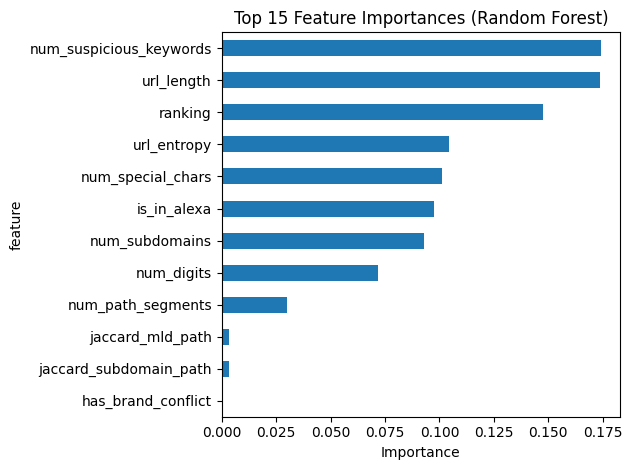

In [24]:
# Get feature importances
importances = final_rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
importance_df.head(15).plot(kind='barh', x='feature', y='importance', legend=False)
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

y_pred_proba = final_rf.predict_proba(X_test_scaled)[:, 1]
y_pred = final_rf.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

AUC: 0.9708151014136736
Precision: 0.9326741473169647
Recall: 0.876213338899906
F1: 0.9035625874502207


The final Random Forest model shows excellent performance, with an AUC of 0.9708, precision of 0.93, recall of 0.88, and F1-score of 0.90. These metrics suggest a strong overall fit, without obvious signs of underfitting (which would show low training and test scores) or overfitting (where test scores would drop relative to training). The confusion matrix confirms that while the model misclassifies some phishing URLs as benign, it maintains a cautious stance by catching the majority of them with high recall. In phishing detection, false negatives (missed phishing) are more dangerous than false positives (flagging a benign URL). Given this, our model's slight bias toward recall over precision aligns well with our risk tolerance.

The feature importance plot highlights that lexical URL features—such as num_suspicious_keywords, url_length, and url_entropy—contribute most heavily to the model’s decisions. This supports the idea that phishing URLs tend to exhibit distinctive patterns in structure and content, even without needing external metadata. Less important features, like has_brand_conflict or Jaccard similarities, may still offer value in edge cases but are not central drivers of classification decisions.

Overall, the model achieves a strong balance of caution and precision, making it a reliable tool for phishing detection in real-world applications.

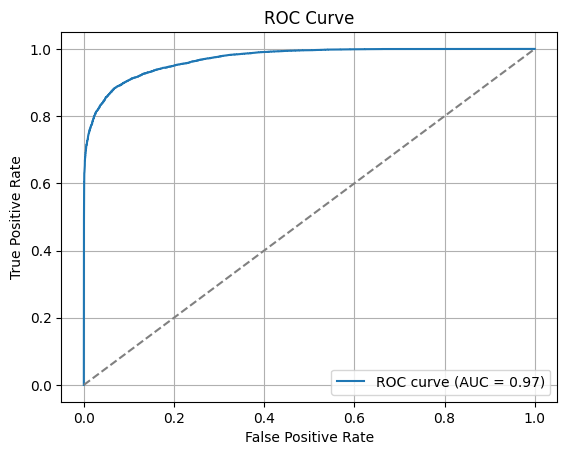

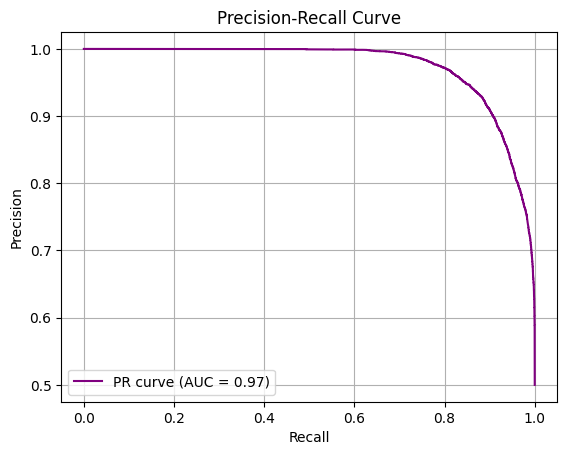

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Assume y_test and y_proba are available from previous steps
# y_proba should be the predicted probabilities for class 1 (phishing)
fpr, tpr, _ = roc_curve(y_test, final_rf.predict_proba(X_test_scaled)[:, 1])
precision, recall, _ = precision_recall_curve(y_test, final_rf.predict_proba(X_test_scaled)[:, 1])

roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [29]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Convert to DataFrame for easier analysis
pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})

# Filter for thresholds where recall is >= 0.95
high_recall = pr_df[pr_df['recall'] >= 0.95]

# Choose threshold with highest precision among them (or balance of choice)
best_thresh = high_recall.sort_values(by='precision', ascending=False).iloc[0]['threshold']

print(f"Selected cautious threshold: {best_thresh:.3f}")


Selected cautious threshold: 0.180


In [30]:
y_pred_adjusted = (y_proba >= best_thresh).astype(int)


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.94      0.77      0.85      9584
           1       0.81      0.95      0.87      9581

    accuracy                           0.86     19165
   macro avg       0.87      0.86      0.86     19165
weighted avg       0.87      0.86      0.86     19165

[[7417 2167]
 [ 477 9104]]


#### Threshold Adjustment for High Recall
By default, classifiers use a threshold of 0.5 to decide whether a URL is phishing or not. However, in security-sensitive applications like phishing detection, missing a phishing URL (false negative) is riskier than flagging a benign URL (false positive). Therefore, we adjusted the classification threshold to favor recall—ensuring we catch as many phishing URLs as possible.

What I did:

- Computed the precision-recall curve to explore how different thresholds affect model performance.
- Filtered for thresholds with recall ≥ 0.95, to ensure I catch almost all phishing URLs.
- Among those, I selected the threshold with the highest precision to reduce false positives as much as possible while still catching phishing attempts.
- I then applied this new threshold to the predicted probabilities to create new class predictions.
- Finally, I evaluated the model again using the updated predictions and printed the updated classification report and confusion matrix.

This approach tailors the model to prioritize caution, which is ideal for security contexts. It helps reduce the chance that dangerous phishing URLs go undetected, even if that means sometimes mistakenly flagging legitimate URLs.



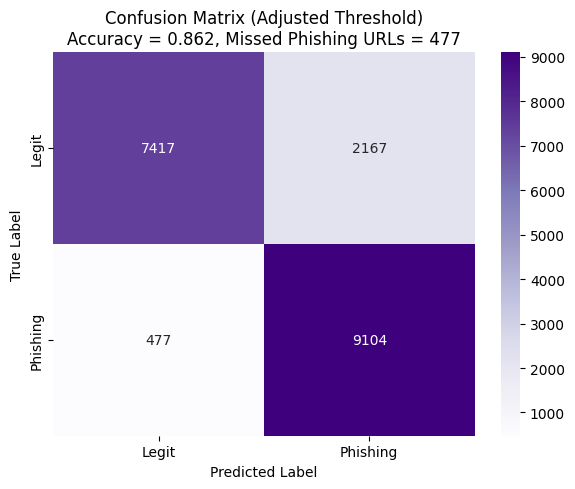

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Recalculate metrics for adjusted threshold
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
tn, fp, fn, tp = cm_adjusted.ravel()
missed_phishing = fn  # false negatives

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Purples', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Adjusted Threshold)\nAccuracy = {accuracy_adjusted:.3f}, Missed Phishing URLs = {missed_phishing}')
plt.tight_layout()
plt.show()


In phishing detection, false negatives (i.e., phishing URLs that are mistakenly labeled as benign) pose a greater risk than false positives. To address this, we adjusted the classification threshold downward from the default 0.5 to a lower value, prioritizing recall over overall accuracy. This means we're now more cautious, aiming to catch more phishing URLs, even if it means mislabeling some legitimate ones.

After lowering the threshold:
- Accuracy dropped from ~91% to 86.2%.
- Recall for phishing URLs improved: we now correctly identify 9,104 phishing URLs out of 9,581.

However, we now misclassify 2,167 legitimate URLs as phishing (false positives).


Next I will explore these phising links that were hard to identify and try to develop new feautures.